In [1]:
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
import torch
import torch.nn as nn
from torchvision import transforms as T
from dataloader.chexpert import ChexpertDataset
import numpy as np
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
import cv2
from PIL import Image
tensor2pli = T.ToPILImage()
pli2tensor = T.ToTensor()
cuda = True
import training.Loader as Loader

#image_size = 384
#patch_size = 24
from salience.Cam_Functions import *
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD


In [2]:
from LRP.LRP_visu import LRP_vis
model_dic = {}

In [3]:
args = type('test', (), {})()
args.deit_tiny_distilled_patch16_224 = False
args.deit_base_distilled_patch16_224 = False
args.deit_base_distilled_patch16_384 = False
args.densnet_121 = False
args.CoAtNet0 = False
args.CoAtNet1 = False
args.CoAtNet2 = False
args.CoAtNet3 = False
args.CoAtNet4 = False
args.ResNN12 = False
args.NativeResNN12 = False




args.base_ckpt = -1
args.ckpt_path = "C:/Users/rober/Desktop/ios/output"
args.train = False

if False:
    args.deit_tiny_distilled_patch16_224 = True
    args.exp_name = "Vit_3_11"
    model_dic = {}
    model = Loader.getNN(args)
    Loader.load(args,model)
    model.target_layers = model.a.blocks[-1].norm1
    #model_dic["Vit1"] = model
    args.deit_tiny_distilled_patch16_224 = False
    model = None

if True:
    args.deit_base_distilled_patch16_224 = True
    args.exp_name = "Vit3_on_class2"
    model = Loader.getNN(args)
    Loader.load(args,model)
    model.target_layers = model.a.blocks[-1].norm1
    model_dic["Vit3"] = model
    args.deit_base_distilled_patch16_224 = False
    model = None
if False:
    args.exp_name = "dens224_ag224_3" 
    args.densnet_121  =  True
    model = Loader.getNN(args)
    Loader.load(args,model)
    model.target_layers = model.a.features[-2].denselayer16.conv2
    print(model.target_layers)
    #model_dic["dens224"] = model

    model = None





Using cache found in C:\Users\rober/.cache\torch\hub\facebookresearch_deit_main


reload last Checkpoint for  deit_16_224_base


In [4]:

for name, m in model_dic.items():
    m.eval()
    if cuda:
        m.cuda()
        
transforms = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
        ]) 
transforms2 = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
        ]) 
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
unorm = UnNormalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD)    
trainset = ChexpertDataset(root="C:/Users/rober/Documents/",cache_dir = None,version="small" ,transforms=transforms)

index = 1

Load the training dataframe into memory.


In [5]:
x = trainset[index]
input_tensor = x[0]

gt = x[1]
if cuda:
    input_tensor = input_tensor.cuda()

#rgb_img = unorm(input_tensor.detach()).cpu().permute(1,2,0).numpy()
#rgb_img2 = in2
#rgb_img /= rgb_img.max()

#fig, (ax1, ax2,ax3) = plt.subplots(nrows=1,ncols = 3, figsize=(16, 16))
#_ = ax1.imshow(rgb_img)
#_ = ax2.imshow(trainset.img)
#_ = ax3.imshow(unorm(transforms2(trainset.img).permute(1,2,0)))
   
#plt.figure()
if len(input_tensor.shape) == 3:
    input_tensor = torch.unsqueeze(input_tensor, 0)
#input_tensor_org = input_tensor

#print(rgb_img.shape,gt[9])
#input_tensor_org.shape
#index+=1
# Note: input_tensor can be a batch tensor with several images!

In [6]:
for name, m in model_dic.items():
    if not "Vit" in name:
        print("is not VIT",name)
        continue
    print("is VIT",name)
    #Hijack attention
    hijack_attention(m,name)

is VIT Vit3


In [7]:
s = torch.nn.Sigmoid()
for name, m in model_dic.items():
    if "Vit" in name:
        m.last_att = []
    with torch.no_grad():
        out = s(m(input_tensor))
    print(int(out[0,0].item()*10000)/10000,"\t",gt[9].item(),"Pneumothorax",)

0.0 	 0.0 Pneumothorax


In [8]:
"Pneumothorax"
import dataloader.siim_acr_pneumothorax_segmentation as ssim
ssim_ds = ssim.SIIMDatasetSingle(root="d:\\ma",cache_dir = None)

GPU: 61 48 12
GPU: 60 48 11


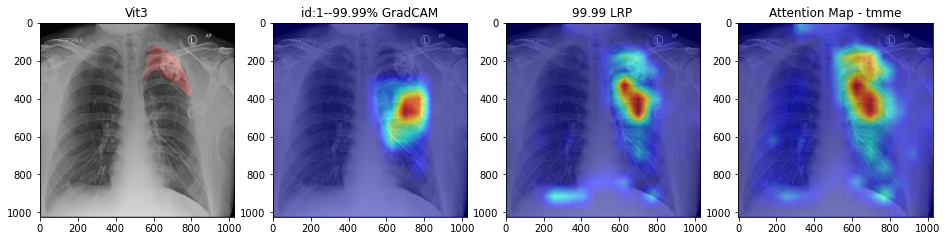

In [12]:
high_res = True
from PIL import ImageFont , ImageDraw 


def showClass(index, seg = False, save_folder=None):
    torch.cuda.empty_cache()
    for name, m in model_dic.items():
        #print(name)
        with torch.no_grad():
            s = torch.nn.Sigmoid()
            if seg:
                x = ssim_ds.getSample(index)
                #print('save')
                #x[0].save(f'C:/Users/rober/Desktop/FP/{index}.png')
                input_tensor = transforms(x[0])
                
                    
                gt = [x[3] for i in range(10)]
            else:
                x = trainset[index]
                input_tensor = x[0]
                gt = x[1]  
            
            if cuda:
                input_tensor = input_tensor.cuda()
            rgb_img = unorm(input_tensor.clone().detach()).cpu().permute(1,2,0).numpy()
            rgb_img /= rgb_img.max()
            if high_res:
                org_input = np.array(x[0])
            else:
                org_input = rgb_img*255
            
            if seg:
                if high_res:
                    rgb_img2 = np.array(x[2])
                else:
                    rgb_img2 =unorm(transforms(x[2])).cpu().permute(1,2,0).numpy()*255
                    
            else:
                rgb_img2 = rgb_img
            
            if len(input_tensor.shape) == 3:
                input_tensor = torch.unsqueeze(input_tensor, 0)
     
            out = s(m(input_tensor))
            
            #print(out)
    
        if "Vit" in name:
            # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
            cam = GradCAM(m, m.target_layers, use_cuda=cuda, reshape_transform=reshape_transform)
            
        else:
            cam = GradCAM(m, m.target_layers, use_cuda=cuda)
        grayscale_cam = cam(input_tensor=input_tensor, target_category=0)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image2(org_input, grayscale_cam)
        #visualization = show_cam_on_image2(rgb_img, grayscale_cam)
        
        if "Vit" in name:
            #mask = attention_vis(out,m.last_att,ramen = 1)
            visualization2,_,out_lrp = LRP_vis(name,m,input_tensor)
            visualization2 = show_cam_on_image2(org_input,visualization2)
            visualization3,_,_ = generate_visualization_tmme(m,input_tensor,class_index=0)
            visualization3 = show_cam_on_image2(org_input,visualization3)
            
            #plt.savefig(f'C:/Users/rober/Desktop/FP/g_{index}.png')
            if not save_folder is None:
                if high_res:
                    font_size = 50
                else:
                    font_size= 14
                font = ImageFont.truetype(r'C:\Users\System-Pc\Desktop\arial.ttf', font_size) 
                padding = np.zeros( (int(font_size+15),)+org_input.shape[1:])
                store_img_left = np.concatenate((padding,org_input,                        
                                            padding,visualization2,
                                            padding,rgb_img2),axis=0)
                store_img_right = np.concatenate((padding,visualization,
                                            padding,visualization3,
                                            padding,rgb_img2),axis=0)
                
                store_img = np.concatenate((store_img_left,store_img_right),axis=1)
                store_img = Image.fromarray((store_img).astype(np.uint8))
                if gt[9] == 1:
                    text = "Pneumothorax (red)"
                else:
                    text = "no Pneumothorax"
                
                draw = ImageDraw.Draw(store_img) 
                imge_w = org_input.shape[0] + int(font_size+15)
                imge_h = org_input.shape[0]
                draw.text((5,5+imge_w*0 ), f"Model: {name}, Prediction: {int(out.item()*10000)/100} %; ptx {gt[9]}", font = font, align ="left") 
                draw.text((5+imge_h,5+imge_w*0), "GradCAM", font = font, align ="center") 
                draw.text((5,5+imge_w*1), "LRP", font = font, align ="center") 
                draw.text((5+imge_h,5+imge_w*1), "TMME", font = font, align ="center") 
                draw.text((5,5+imge_w*2), text, font = font, align ="center") 
                
                #font = ImageFont.truetype(r'C:\Users\System-Pc\Desktop\arial.ttf', font_size) 
                #store_img = np.concatenate((org_input,visualization,visualization2,visualization3,rgb_img2),axis=1)
                #store_img = np.concatenate((np.zeros( (int(font_size+15),)+store_img.shape[1:]),store_img),axis=0)
                #store_img = Image.fromarray((store_img).astype(np.uint8))
                #draw = ImageDraw.Draw(store_img) 
                #imge_w = org_input.shape[0]
                #draw.text((5+imge_w*0, 5), f"Model: {name}, Prediction: {int(out.item()*10000)/100} %; ptx {gt[9]}", font = font, align ="left") 
                #draw.text((20+imge_w*1, 5), "GradCAM", font = font, align ="center") 
                #draw.text((20+imge_w*2, 5), "LRP", font = font, align ="center") 
                #draw.text((20+imge_w*3, 5), "TMME", font = font, align ="center") 
                #draw.text((20+imge_w*4, 5), text, font = font, align ="center") 
                #store_img.show() 
                store_img.save(f'C:/Users/rober/Desktop/{save_folder}/p_{index}.png')
            else:
                fig, (ax1, ax2,ax3,ax4) = plt.subplots(nrows=1,ncols = 4, figsize=(16, 16))
            
                ax1.set_title(name)
                ax2.set_title(f'id:{index}--{int(out.item()*10000)/100}% GradCAM')
                ax3.set_title(f'{int(s(torch.tensor(out_lrp)).item()*10000)/100} LRP')
                ax4.set_title('Attention Map - tmme')
                #ax5.set_title('Attention Map - blende**2')
                _ = ax1.imshow(rgb_img2/rgb_img2.max())
                _ = ax2.imshow(visualization)
                _ = ax3.imshow(visualization2)
                _ = ax4.imshow(visualization3)
                #_ = ax5.imshow(visualization4)
                #_ = ax6.imshow(rgb_img)
        else:
            fig, (ax1, ax2,ax3) = plt.subplots(nrows=1,ncols = 3, figsize=(16, 16))
            #print(f"Pneumothorax -- {int(out.item()*10000)/100} % {name} {gt[9]}")

            ax1.set_title(name)
            ax2.set_title(f'id:{0}--{int(out.item()*10000)/100}% GradCAM')
            _ = ax1.imshow(rgb_img2)
            _ = ax2.imshow(visualization)
            _ = ax3.imshow(rgb_img2)
            #_ = ax4.imshow(visualization)
            #_ = ax5.imshow(visualization)
printGPUstorage()
showClass(1,seg = True)#save_folder='\True_Positiv'
printGPUstorage()

In [10]:
#showClass(1,seg = True)
#showClass(3,seg = True)
#showClass(4,seg = True)
#showClass(10,seg = True)
#showClass(46,seg = True)
#showClass(61,seg = True)
#showClass(86,seg = True)


In [11]:
#showClass(106,seg = True)
#showClass(125,seg = True)
#showClass(130,seg = True)
#showClass(142,seg = True)
#showClass(154,seg = True)
#showClass(155,seg = True)

#showClass(index)
#index+=1

In [12]:
print(model_dic.keys())

dict_keys(['Vit3'])


In [17]:
from os import listdir
from os.path import isfile, join



idx_name = ["True_Positiv","False_Negative","False_Positiv","True_Negative"]


def reload_image_id(idx, batch1 = "batch2"):
    path = (f'C:/Users/rober/Desktop/{batch1}/{idx_name[idx]}/')
    return [int(f[2:-4]) for f in listdir(path) if (isfile(join(path, f))) and '.png' in f]
    


sub_folder = ["batch2/","batch2/","batch2/","batch2/",]
idx_tp = reload_image_id(0)
idx_fn = reload_image_id(1)
idx_fp = reload_image_id(2)
idx_tn = reload_image_id(3)
idx_list = [idx_tp,idx_fn,idx_fp,idx_tn]
print(idx_list)

[[10361, 11380, 11604, 1295, 1903, 1981, 2639, 3371, 4045, 4459, 4943, 5449, 5500, 5719, 637, 6558, 6720, 6946, 7600, 8898], [10453, 11109, 11192, 12382, 12839, 1620, 2371, 271, 298, 302, 5006, 5193, 6042, 6764, 6769, 7327, 7416, 9242, 9649, 9964], [10086, 10374, 10532, 10855, 12642, 1416, 1837, 1864, 2052, 2330, 2349, 3411, 3596, 504, 6188, 7207, 851, 8867, 9400, 9573], [10182, 10846, 11975, 12295, 12371, 2860, 4697, 4797, 5021, 5480, 5483, 727, 7601, 7629, 8739, 8899, 9042, 9311, 9628, 976]]


In [14]:
import numpy as np


In [15]:
x = np.load("../output/Vit3_on_class2/ssim_prep.npy")
#x = np.array([[0,1,1],[0.2,.8,.9]])
#idx = [i for i in range(x.shape[1])]
#np.stack((x,np.array(idx)))
cutoff = 0.5

idx_tp = np.where(np.logical_and(x[0] == 1,x[1] >=cutoff))[0]
idx_fn = np.where(np.logical_and(x[0] == 1,x[1] < cutoff))[0]
idx_fp = np.where(np.logical_and(x[0] == 0,x[1] >=cutoff))[0]
idx_tn = np.where(np.logical_and(x[0] == 0,x[1] < cutoff))[0]
idx_list = [idx_tp,idx_fn,idx_fp,idx_tn]
idx_name = ["True_Positiv","False_Negative","False_Positiv","True_Negative"]
sub_folder = ["","","","",]
idx_f = np.where(x[0] == 0)

In [16]:
ssim_ds.data.df["Prediction"] = x[1].round(decimals=5)*100
print(list([(idx_name[i],len(idx_list[i]))] for i in range(len(idx_name))))
0/0

[[('True_Positiv', 3202)], [('False_Negative', 374)], [('False_Positiv', 1722)], [('True_Negative', 7656)]]


ZeroDivisionError: division by zero

In [ ]:
np.random.seed(512)
high_res = True
for i in range(3,len(idx_name)):
    idx = idx_list[i]
    labels = np.sort(np.random.choice(idx, size=(20), replace=False, p=None))
    print(labels)
    df = ssim_ds.data.df.iloc[labels].copy().drop("EncodedPixels",1)
    df.to_csv(f"C:/Users/rober/Desktop/{sub_folder[i]+idx_name[i]}/info.csv")
    df.to_excel(f"C:/Users/rober/Desktop/{sub_folder[i]+idx_name[i]}/info.xls")

    for l in labels:
        showClass(l,seg = True,save_folder=sub_folder[i]+idx_name[i])


[  727   976  2860  4697  4797  5021  5480  5483  7601  7629  8739  8899
  9042  9311  9628 10182 10846 11975 12295 12371]


In [ ]:
idx = idx_list[2]
labels = np.sort(np.random.choice(idx, size=(20), replace=False, p=None))
#for l in labels:
#    showClass(l,seg = True)

In [ ]:
idx = idx_list[3]
labels = np.sort(np.random.choice(idx, size=(20), replace=False, p=None))
#for l in labels:
#    showClass(l,seg = True)